### Find the theoretical contribution from the reflected path
# $E(r) = \frac{1}{r} \times cos^2(\theta) \times Fresnel\_coefficients(90°-\theta)$
- $\frac{1}{r}$ is the distance factor
- $cos^2(\theta)$ is an approximate beam pattern factor
- $Fresnel\_coefficients(90°-\theta)$ is the reflection coefficient for the given angle

~~~
_________________________________________________________
    |                       |                       |
    |                  R   / \                      |
    |                 e     |                       |
    |                f   /     \                    |
    |               l       |                       |
    |              e   /         \                  |
    |             c         |                       |
    |            t   /             \                |
    |           e           |                       |
    |          d   /                 \              |
    |                       | 90-Θ  /              |
    |            /                 /   \            |
    |                       |___-`                  |
    |          /                         \          |
    |                       |                       |
    |        /                             \        |
    |                       |                       |
    |      /                                 \      |
    |                       |                       |
    |    /                                     \    |
    |                       |                       |
    |  /                                       --\  |
    |                       |___             /      |
    |/                          |           /  Θ   \|
   RX _  _  _  _  _  _  _  _|_ _| _  _  _  _| _  _  TX
        <- Direct Path
~~~


Fresnel coefficients:
- For VPol (perpendicular):
    - ## $r_{\perp} = \frac{n_1 \cos(\theta_i) - n_2 \cos(\theta_t)}{n_1 \cos(\theta_i) + n_2 \cos(\theta_t)}$
        - $r$ is the reflection coefficient
    - ## $t_{\perp} = \frac{2 n_1 \cos(\theta_i)}{n_1 \cos(\theta_i) + n_2 \cos(\theta_t)}$
        - $t$ is the transmission coefficient
- For HPol (parallel):
    - ## $r_{\parallel} = \frac{n_2 \cos(\theta_i) - n_1 \cos(\theta_t)}{n_2 \cos(\theta_i) + n_1 \cos(\theta_t)}$
    - ## $t_{\parallel} = \frac{2 n_1 \cos(\theta_i)}{n_2 \cos(\theta_i) + n_1 \cos(\theta_t)}$
- where:
    - $\theta_i$ is the angle of incidence (angle between the incident ray and the normal)
    - $\theta_t$ is the angle of transmission (angle between the transmitted ray and the normal)
    - $n_1$ is the refractive index of the first medium (air, n=1)
    - $n_2$ is the refractive index of the second medium (ice, n=1.73)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

distance = 34.63  # m, distance between TX and RX
depths = np.arange(1, 56, 1)  # m, depth of the TX [1, 55] m

In [2]:
def find_theta(depth, distance):
    """ Find the angle of incidence theta given the depth and distance between TX and RX """
    return np.arctan(depth / distance)

# calculate the distance of the reflected path
def find_reflected_path_length(depth, distance):
    """ Find the length of the reflected path given the depth and distance between TX and RX """
    return np.sqrt(distance**2 + (2 * depth)**2)

thetas = find_theta(depths, distance)  # radians

reflected_path_lengths = find_reflected_path_length(depths, distance)  # m

In [3]:
def E_r_reflect(r, theta, pol, n=1.73):
    """ Calculate the electric field magnitude of the reflected path given the distance r and angle of incidence theta
    using the formula:
    E(r) = (1/r) * cos^2(theta) * Fresnel_coefficients(90°-theta)
    where Fresnel_coefficients(90°-theta) is calculated for VPol and n=1.73 (ice)
    """
    d_factor = 1 / r
    beam_factor = np.cos(theta)**2
    if pol == 'HPol':
        fresnel_coeff = abs((n * np.cos(np.pi/2 - theta) - 1 * np.cos(theta)) /
                            (n * np.cos(np.pi/2 - theta) + 1 * np.cos(theta)))
    elif pol == 'VPol':
        fresnel_coeff = abs((1 * np.cos(np.pi/2 - theta) - n * np.cos(theta)) /
                            (1 * np.cos(np.pi/2 - theta) + n * np.cos(theta)))
    else:
        raise ValueError("pol must be 'HPol' or 'VPol'")

    return d_factor * beam_factor * fresnel_coeff

def E_r_direct(r):
    """ Calculate the electric field magnitude of the direct path given the distance r
    using the formula:
    E(r) = 1/r
    """
    return 1 / r

In [4]:
vpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='VPol')
hpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='HPol')

vpol_E_r_direct = E_r_direct(distance)
hpol_E_r_direct = E_r_direct(distance)

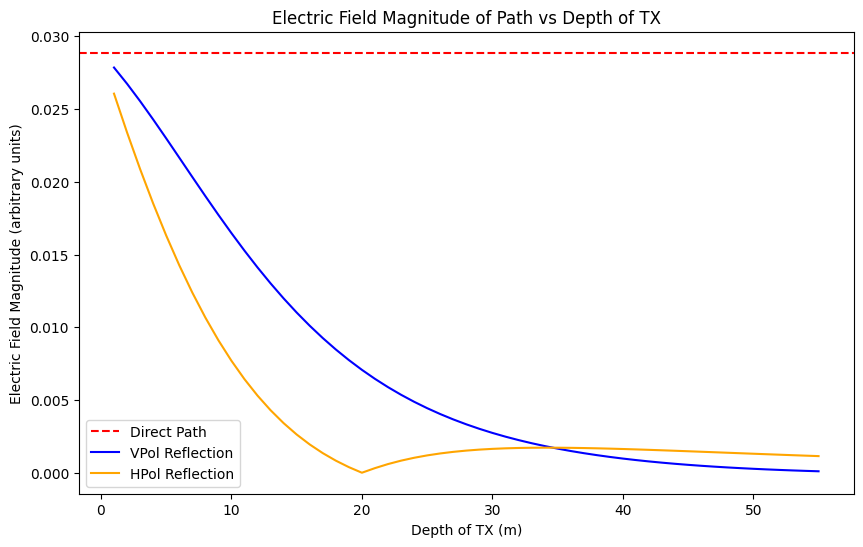

In [5]:
plt.figure(figsize=(10, 6))
plt.axhline(hpol_E_r_direct, color='red', linestyle='--', label='Direct Path')
plt.plot(depths, vpol_E_r_reflect, label='VPol Reflection', color='blue')
plt.plot(depths, hpol_E_r_reflect, label='HPol Reflection', color='orange')
plt.xlabel('Depth of TX (m)')
plt.ylabel('Electric Field Magnitude (arbitrary units)')
plt.title('Electric Field Magnitude of Path vs Depth of TX')
plt.legend()

In [6]:
vpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='VPol')
hpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='HPol')
vpol_E_r_reflect = np.array(vpol_E_r_reflect)
hpol_E_r_reflect = np.array(hpol_E_r_reflect)

vpol_E_r_direct = E_r_direct(distance)
hpol_E_r_direct = E_r_direct(distance)
vpol_E_r_direct = np.array(vpol_E_r_direct)
hpol_E_r_direct = np.array(hpol_E_r_direct)

# print(shapes := (vpol_E_r_reflect, hpol_E_r_reflect, vpol_E_r_direct, hpol_E_r_direct))

In [7]:
# normalize the E_r values so that the direct path is 1
vpol_E_r_reflect = (1 / vpol_E_r_direct) * vpol_E_r_reflect
hpol_E_r_reflect = (1 / hpol_E_r_direct) * hpol_E_r_reflect
vpol_E_r_direct = vpol_E_r_direct / vpol_E_r_direct
hpol_E_r_direct = hpol_E_r_direct / hpol_E_r_direct

print(vpol_E_r_direct, hpol_E_r_direct)

1.0 1.0


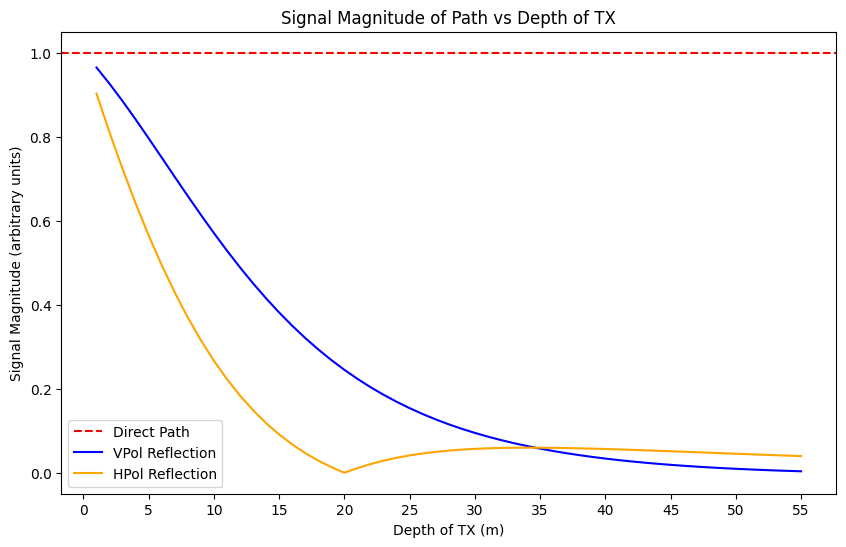

In [8]:
dir = 'My S12'
plt.figure(figsize=(10, 6))
plt.axhline(hpol_E_r_direct, color='red', linestyle='--', label='Direct Path')
plt.plot(depths, vpol_E_r_reflect, label='VPol Reflection', color='blue')
plt.plot(depths, hpol_E_r_reflect, label='HPol Reflection', color='orange')
plt.xlabel('Depth of TX (m)')
# x ticks every 5
plt.xticks(np.arange(0, max(depths)+1, 5))
plt.ylabel('Signal Magnitude (arbitrary units)')
plt.title('Signal Magnitude of Path vs Depth of TX')
plt.legend()
plt.savefig(f'{dir}/2. Signal Magnitude vs Depth.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'{dir}/test_Electric_Field_Magnitude_vs_Depth.png', dpi=300, bbox_inches='tight')

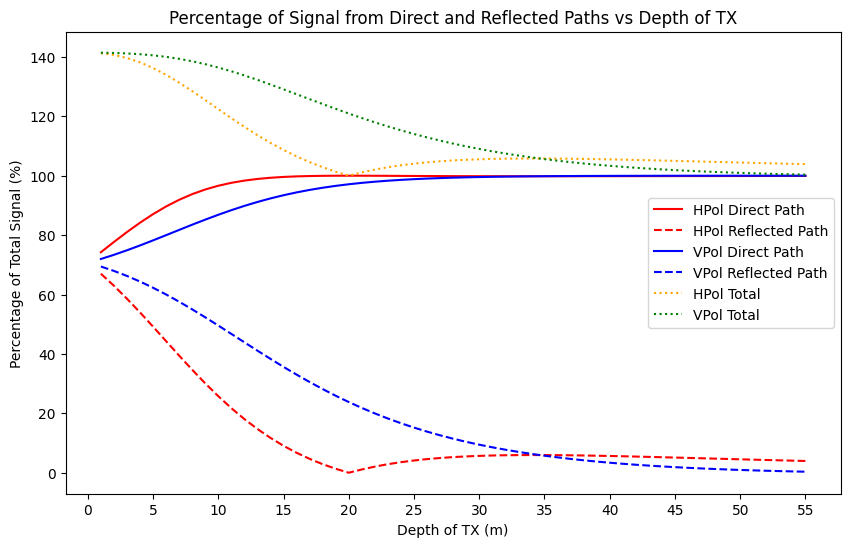

In [10]:
# calculate the percentage of the signal coming from the direct and reflected paths
hpol_total = np.sqrt(hpol_E_r_direct**2 + hpol_E_r_reflect**2)
vpol_total = np.sqrt(vpol_E_r_direct**2 + vpol_E_r_reflect**2)

hpol_direct = (hpol_E_r_direct / hpol_total) * 100
hpol_reflect = (hpol_E_r_reflect / hpol_total) * 100
vpol_direct = (vpol_E_r_direct / vpol_total) * 100
vpol_reflect = (vpol_E_r_reflect / vpol_total) * 100

# plot the percentages
plt.figure(figsize=(10, 6))
plt.plot(depths, hpol_direct, label='HPol Direct Path', color='red')
plt.plot(depths, hpol_reflect, label='HPol Reflected Path', color='red', linestyle='--')
plt.plot(depths, vpol_direct, label='VPol Direct Path', color='blue')
plt.plot(depths, vpol_reflect, label='VPol Reflected Path', color='blue', linestyle='--')

# plot the sum of the percentages to check that they add up to 100%
plt.plot(depths, hpol_direct + hpol_reflect, label='HPol Total', color='orange', linestyle=':')
plt.plot(depths, vpol_direct + vpol_reflect, label='VPol Total', color='green', linestyle=':')

plt.xlabel('Depth of TX (m)')
# x ticks every 5
plt.xticks(np.arange(0, max(depths)+1, 5))
plt.ylabel('Percentage of Total Signal (%)')
plt.title('Percentage of Signal from Direct and Reflected Paths vs Depth of TX')
plt.legend()
plt.savefig(f'{dir}/2. Percentage of Signal from Direct and Reflected Paths vs Depth.png', dpi=300, bbox_inches='tight')